In [108]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

import nibabel as nib
import nilearn.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import hcp_utils as hcp


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler



import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
file_path = "parcellations"
file_list = os.listdir(file_path)
mmp = []
ca = []
for i in file_list:
    if "mmp" in i:
        mmp_file = np.load(file_path + "/" + i)
        if mmp_file.shape == (3600, 379):
            mmp.append(np.load(file_path + "/" + i))

In [3]:
np.load("parcellations/sub-193845_task-rest_parcellation-ca_timeseries.npy").shape

(3600, 718)

In [4]:
open_access_data = pd.read_csv("unrestricted_data.csv")
restricted_data = pd.read_csv("RESTRICTED_BEHAVIORAL_DATA.csv")
subject_data = open_access_data.merge(restricted_data, how = 'inner', on = 'Subject')

file_path = "parcellations"
file_list = os.listdir(file_path)
mmp = {}
ca = {}
for filename in file_list:
    subject_id = filename[4:10]

    if subject_id.isdigit():
        subject_id = int(subject_id)

        if "mmp" in filename:
            mmp_file = np.load(file_path + "/" + filename)
            if mmp_file.shape == (3600, 379):
                mmp[subject_id] = mmp_file
        if "ca" in filename:
            ca_file = np.load(file_path + "/" + filename)
            if ca_file.shape == (3600, 718):
                ca[subject_id] = ca_file

mmp_data = pd.DataFrame({
    'Subject': list(mmp.keys()),
    'Brain_Data': list(mmp.values())  # (3600, 379) arrays
})


mmp_data = subject_data.merge(mmp_data, on='Subject', how='inner')

ca_data = pd.DataFrame({
    'Subject': list(ca.keys()),
    'Brain_Data': list(ca.values())  # (3600, 718) arrays
})


ca_data = subject_data.merge(ca_data, on='Subject', how='inner')


In [5]:
mmp_data["Handedness_Cat"] = mmp_data["Handedness"].apply(lambda x: "Left" if x < 0 else "Right")

In [6]:
hand_data = mmp_data[["Subject", "Gender", "Race", "Handedness", "Handedness_Cat"]]
hand_data

,Subject,Gender,Race,Handedness,Handedness_Cat
0,100610,M,White,85,Right
1,102311,F,White,10,Right
2,102816,F,Black or African Am.,100,Right
3,104416,F,Asian/Nat. Hawaiian/Othr Pacific Is.,65,Right
4,105923,F,White,35,Right
...,...,...,...,...,...
167,943862,M,White,95,Right
168,958976,M,White,85,Right
169,966975,M,White,40,Right
170,971160,M,White,80,Right


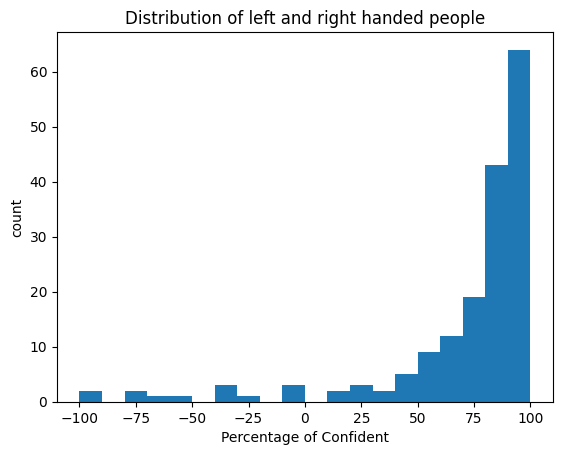

In [7]:
plt.hist(hand_data["Handedness"], bins = 20)
plt.xlabel("Percentage of Confident")
plt.ylabel("count")
plt.title("Distribution of left and right handed people")
plt.show();

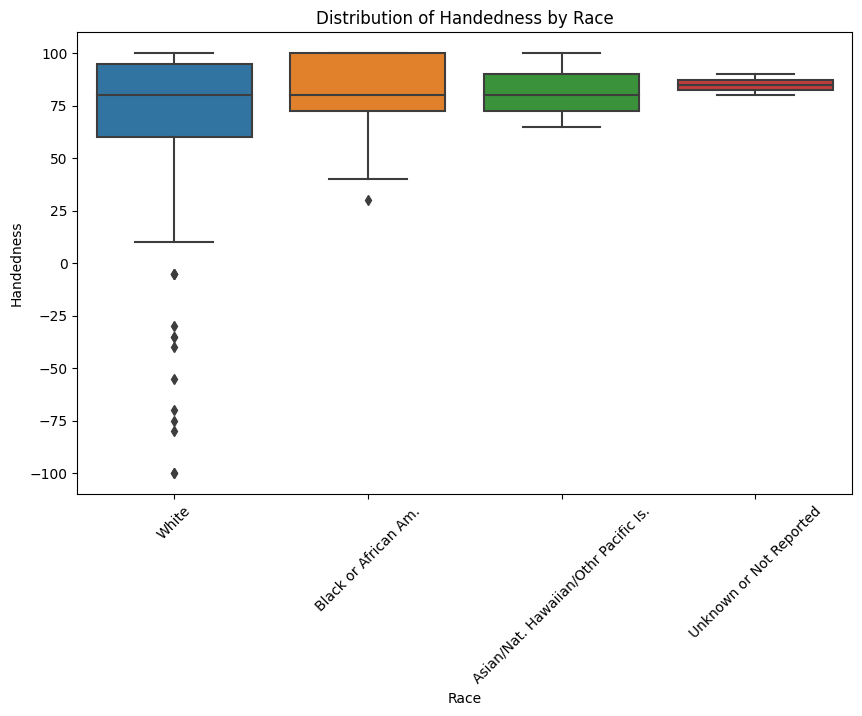

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=hand_data, x='Race', y='Handedness')
plt.title("Distribution of Handedness by Race")
plt.xlabel("Race")
plt.ylabel("Handedness")
plt.xticks(rotation=45)
plt.show()

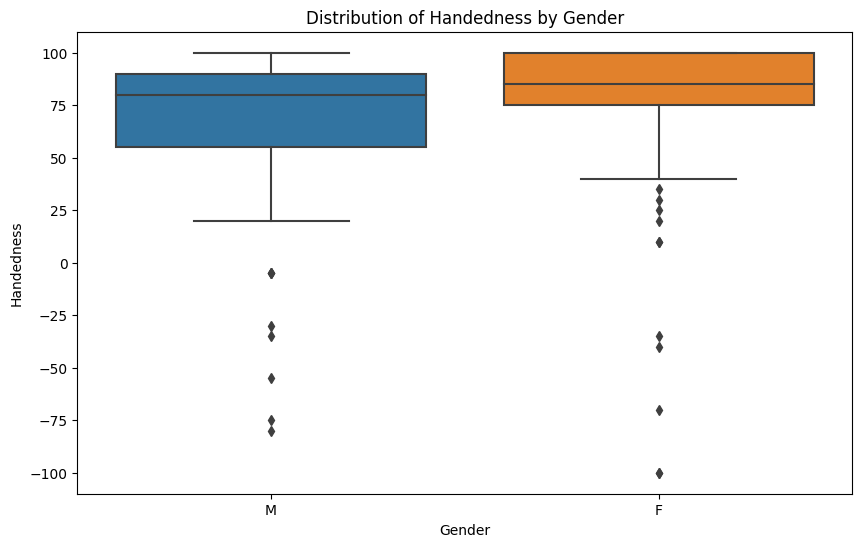

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=hand_data, x='Gender', y='Handedness')
plt.title("Distribution of Handedness by Gender")
plt.xlabel("Gender")
plt.ylabel("Handedness")
plt.show()

In [10]:
correlation_matrix_list = []
for i in range(mmp_data.shape[0]):
    person = mmp_data["Brain_Data"][i]
    #get matrix
    person_matrix = np.corrcoef(person.T)
    #append to list
    correlation_matrix_list.append(person_matrix)
#append to column
mmp_data["correlation_matrix"] = correlation_matrix_list

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [11]:
brain_region = list(hcp.mmp.labels.values())

In [12]:
print(brain_region)

['', 'L_V1', 'L_MST', 'L_V6', 'L_V2', 'L_V3', 'L_V4', 'L_V8', 'L_4', 'L_3b', 'L_FEF', 'L_PEF', 'L_55b', 'L_V3A', 'L_RSC', 'L_POS2', 'L_V7', 'L_IPS1', 'L_FFC', 'L_V3B', 'L_LO1', 'L_LO2', 'L_PIT', 'L_MT', 'L_A1', 'L_PSL', 'L_SFL', 'L_PCV', 'L_STV', 'L_7Pm', 'L_7m', 'L_POS1', 'L_23d', 'L_v23ab', 'L_d23ab', 'L_31pv', 'L_5m', 'L_5mv', 'L_23c', 'L_5L', 'L_24dd', 'L_24dv', 'L_7AL', 'L_SCEF', 'L_6ma', 'L_7Am', 'L_7PL', 'L_7PC', 'L_LIPv', 'L_VIP', 'L_MIP', 'L_1', 'L_2', 'L_3a', 'L_6d', 'L_6mp', 'L_6v', 'L_p24pr', 'L_33pr', 'L_a24pr', 'L_p32pr', 'L_a24', 'L_d32', 'L_8BM', 'L_p32', 'L_10r', 'L_47m', 'L_8Av', 'L_8Ad', 'L_9m', 'L_8BL', 'L_9p', 'L_10d', 'L_8C', 'L_44', 'L_45', 'L_47l', 'L_a47r', 'L_6r', 'L_IFJa', 'L_IFJp', 'L_IFSp', 'L_IFSa', 'L_p9-46v', 'L_46', 'L_a9-46v', 'L_9-46d', 'L_9a', 'L_10v', 'L_a10p', 'L_10pp', 'L_11l', 'L_13l', 'L_OFC', 'L_47s', 'L_LIPd', 'L_6a', 'L_i6-8', 'L_s6-8', 'L_43', 'L_OP4', 'L_OP1', 'L_OP2-3', 'L_52', 'L_RI', 'L_PFcm', 'L_PoI2', 'L_TA2', 'L_FOP4', 'L_MI', 'L_Pir'

### Try for SVM

In [35]:

def feature_row_get(target):
    target_index = brain_region.index(target)
    target_row = mmp_data['correlation_matrix'].apply(lambda x: x[target_index])
    return target_row

In [36]:
#left 
#MTG.L
    #one to one
        #L_MT
    #all
        #L_MT (middle temporal visual motion complex)
        #L_MST (medial superior temporal area)
        #L_PIT (posterior inferior temporal area)
#ACC.L
    #L_a24
    # L_p24
    # L_24dd
    # L_24dv
    # L_a24pr
    # L_p24pr
    # L_d32
    # L_a32pr
    # L_25
    # L_33pr
#MCC.L
    #L_24dd
    # L_24dv
    # L_23c
    # L_23d

In [37]:
semi_MTG = feature_row_get("L_MT")

semi_ACC_1 = feature_row_get("L_a24")
semi_ACC_2 = feature_row_get("L_p24")
semi_ACC_3 = feature_row_get("L_24dd")
semi_ACC_4 = feature_row_get("L_24dv")
semi_ACC_5 = feature_row_get("L_a24pr")
semi_ACC_6 = feature_row_get("L_p24pr")
semi_ACC_7 = feature_row_get("L_d32")
semi_ACC_8 = feature_row_get("L_a32pr")
semi_ACC_9 = feature_row_get("L_25")
semi_ACC_10 = feature_row_get("L_33pr")

semi_MCC_1 = feature_row_get("L_24dd")
semi_MCC_2 = feature_row_get("L_24dv")
semi_MCC_3 = feature_row_get("L_23c")
semi_MCC_4 = feature_row_get("L_23d")

In [38]:
#right
#ANG.R
    #R_PGp (posterior PG area)
    # R_PGi (inferior PG area)
    # R_PGs (superior PG area)

#AMYG.R
    #amygdala_right


In [39]:
semi_ANG_1 = feature_row_get("R_PGp")
semi_ANG_2 = feature_row_get("R_PGi")
semi_ANG_3 = feature_row_get("R_PGs")

semi_AMYG = feature_row_get("amygdala_right")

In [40]:
new_1 = feature_row_get("L_45")
new_2 = feature_row_get("L_10d")
new_3 = feature_row_get("L_10v")
new_4 = feature_row_get("L_10r")
new_5 = feature_row_get("L_a10p")
new_6 = feature_row_get("L_10pp")

new_7 = feature_row_get("L_PF")
new_8 = feature_row_get("L_PFt")
new_9 = feature_row_get("L_PFop")
new_10 = feature_row_get("L_PFm")


new_11 = feature_row_get("L_3b")
new_12 = feature_row_get("L_1")
new_13 = feature_row_get("L_2")


new_14 = feature_row_get("R_3b")
new_15 = feature_row_get("R_1")
new_16 = feature_row_get("R_2")

new_17 = feature_row_get("R_6ma")
new_18 = feature_row_get("R_6mp")
new_19 = feature_row_get("R_SCEF")


In [41]:
feature_data = mmp_data[["Handedness", "Handedness_Cat", "correlation_matrix"]]
feature_data['matrix_mean'] = mmp_data['correlation_matrix'].apply(lambda x: np.mean(x))
feature_data["semi_MTG"] = semi_MTG

feature_data["semi_ACC_1"] = semi_ACC_1
feature_data["semi_ACC_2"] = semi_ACC_2
feature_data["semi_ACC_3"] = semi_ACC_3
feature_data["semi_ACC_4"] = semi_ACC_4
feature_data["semi_ACC_5"] = semi_ACC_5
feature_data["semi_ACC_6"] = semi_ACC_6
feature_data["semi_ACC_7"] = semi_ACC_7
feature_data["semi_ACC_8"] = semi_ACC_8
feature_data["semi_ACC_9"] = semi_ACC_9
feature_data["semi_ACC_10"] = semi_ACC_10

feature_data["semi_MCC_1"] = semi_MCC_1
feature_data["semi_MCC_2"] = semi_MCC_2
feature_data["semi_MCC_3"] = semi_MCC_3
feature_data["semi_MCC_4"] = semi_MCC_4




feature_data["semi_ANG_1"] = semi_ANG_1
feature_data["semi_ANG_2"] = semi_ANG_2
feature_data["semi_ANG_3"] = semi_ANG_3

feature_data["semi_AMYG"] = semi_AMYG


feature_data["new_1"] = new_1
feature_data["new_2"] = new_2
feature_data["new_3"] = new_3
feature_data["new_4"] = new_4
feature_data["new_5"] = new_5
feature_data["new_6"] = new_6
feature_data["new_7"] = new_7
feature_data["new_8"] = new_8
feature_data["new_9"] = new_9
feature_data["new_10"] = new_10
feature_data["new_11"] = new_11
feature_data["new_12"] = new_12
feature_data["new_13"] = new_13
feature_data["new_14"] = new_14
feature_data["new_15"] = new_15
feature_data["new_16"] = new_16
feature_data["new_17"] = new_17
feature_data["new_18"] = new_18
feature_data["new_19"] = new_19



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [42]:
def flatten_features(row):
    """
    Given a single row of the DataFrame,
    return a 1D numpy array of all features to be used by the model.
    """
    # Example: Flatten correlation_matrix (if it's a 2D 3x3 matrix, that becomes 9 values)
    corr_mat = np.array(row["correlation_matrix"]).flatten()
    
    # Flatten each 'semi_*' array (each is length 3 in your example)
    semi_MTG = np.array(row["semi_MTG"])

    semi_ACC_1 = np.array(row["semi_ACC_1"])
    semi_ACC_2 = np.array(row["semi_ACC_2"])
    semi_ACC_3 = np.array(row["semi_ACC_3"])
    semi_ACC_4 = np.array(row["semi_ACC_4"])
    semi_ACC_5 = np.array(row["semi_ACC_5"])
    semi_ACC_6 = np.array(row["semi_ACC_6"])
    semi_ACC_7 = np.array(row["semi_ACC_7"])
    semi_ACC_8 = np.array(row["semi_ACC_8"])
    semi_ACC_9 = np.array(row["semi_ACC_9"])
    semi_ACC_10 = np.array(row["semi_ACC_10"])

    semi_MCC_1 = np.array(row["semi_MCC_1"])
    semi_MCC_2 = np.array(row["semi_MCC_2"])
    semi_MCC_3 = np.array(row["semi_MCC_3"])
    semi_MCC_4 = np.array(row["semi_MCC_4"])


    semi_ANG_1 = np.array(row["semi_ANG_1"])
    semi_ANG_2 = np.array(row["semi_ANG_2"])
    semi_ANG_3 = np.array(row["semi_ANG_3"])

    semi_AMYG = np.array(row["semi_AMYG"])
    

    new_1 = np.array(row["new_1"])
    new_2 = np.array(row["new_2"])
    new_3 = np.array(row["new_3"])
    new_4 = np.array(row["new_4"])
    new_5 = np.array(row["new_5"])
    new_6 = np.array(row["new_6"])
    new_7 = np.array(row["new_7"])
    new_8 = np.array(row["new_8"])
    new_9 = np.array(row["new_9"])
    new_10 = np.array(row["new_10"])
    new_11 = np.array(row["new_11"])
    new_12 = np.array(row["new_12"])
    new_13 = np.array(row["new_13"])
    new_14 = np.array(row["new_14"])
    new_15 = np.array(row["new_15"])
    new_16 = np.array(row["new_16"])
    new_17 = np.array(row["new_17"])
    new_18 = np.array(row["new_18"])
    new_19 = np.array(row["new_19"])

    
    # Concatenate them into one array
    all_features = np.concatenate([
        semi_MTG, 

        semi_ACC_1,
        semi_ACC_2,
        semi_ACC_3,
        semi_ACC_4,
        semi_ACC_5,
        semi_ACC_6,
        semi_ACC_7,
        semi_ACC_8,
        semi_ACC_9,
        semi_ACC_10,

        semi_MCC_1,
        semi_MCC_2,
        semi_MCC_3,
        semi_MCC_4,

        semi_ANG_1, 
        semi_ANG_2, 
        semi_ANG_3, 
        semi_AMYG, 
        
        new_1, 
        new_2, 
        new_3, 
        new_4, 
        new_5, 
        new_6,
        new_7,
        new_8,
        new_9,
        new_10,
        new_11,
        new_12,
        new_13,
        new_14,
        new_15,
        new_16,
        new_17,
        new_18,
        new_19
    ])
    
    return all_features

In [43]:
test_result = []

In [44]:
feature_data_all = feature_data.copy()

In [46]:
filtered_df = feature_data[(feature_data['Handedness'] > 25) | (feature_data['Handedness'] < -25)]

# Separate into left and right handed
left_handed = filtered_df[filtered_df['Handedness'] < 0]
right_handed = filtered_df[filtered_df['Handedness'] > 0]

# Determine the number of samples to select from the right-handed data
num_samples = min(len(left_handed), len(right_handed))

# Randomly sample from the right-handed data
right_handed_sample = right_handed.sample(n=num_samples, random_state=42)

# Combine the left and right handed data
final_df = pd.concat([left_handed, right_handed_sample])

# Optionally shuffle the final dataframe to mix left and right handed samples
final_df = final_df.sample(frac=1).reset_index(drop=True)

feature_data = final_df


In [47]:
test_result = []
trial_ci = []
trial_acc = []

for i in range(20):
    
    # Now apply this function to each row in the DataFrame to create your X matrix:
    X_list = feature_data.apply(flatten_features, axis=1)
    # X_list will be a column of arrays. Convert to a 2D array:
    X = np.vstack(X_list.values)

    # y is simply the "Handedness" column:
    y = feature_data["Handedness_Cat"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        # random_state=42, 
        test_size=0.5
    )


    model_class = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", probability=True, C=1.0))
    ])
    model_class.fit(X_train, y_train)
    y_pred = model_class.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy of SVM Model:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)



    n_test = len(y_test)
    z_value = 1.96  # for ~95% CI
    std_error = math.sqrt(accuracy * (1 - accuracy) / n_test)

    ci_lower = accuracy - z_value * std_error
    ci_upper = accuracy + z_value * std_error

    print(f"95% CI for Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")

    trial_ci += [[ci_lower, ci_upper]]
    trial_acc += [accuracy]
    test_result += [accuracy]

np.mean(test_result)

Accuracy of SVM Model: 0.4
Confusion Matrix:
 [[4 0]
 [6 0]]
95% CI for Accuracy: [0.0964, 0.7036]
Accuracy of SVM Model: 0.3
Confusion Matrix:
 [[3 0]
 [7 0]]
95% CI for Accuracy: [0.0160, 0.5840]
Accuracy of SVM Model: 0.3
Confusion Matrix:
 [[0 7]
 [0 3]]
95% CI for Accuracy: [0.0160, 0.5840]
Accuracy of SVM Model: 0.4
Confusion Matrix:
 [[4 0]
 [6 0]]
95% CI for Accuracy: [0.0964, 0.7036]
Accuracy of SVM Model: 0.4
Confusion Matrix:
 [[0 6]
 [0 4]]
95% CI for Accuracy: [0.0964, 0.7036]
Accuracy of SVM Model: 0.3
Confusion Matrix:
 [[0 7]
 [0 3]]
95% CI for Accuracy: [0.0160, 0.5840]
Accuracy of SVM Model: 0.5
Confusion Matrix:
 [[2 3]
 [2 3]]
95% CI for Accuracy: [0.1901, 0.8099]
Accuracy of SVM Model: 0.6
Confusion Matrix:
 [[3 2]
 [2 3]]
95% CI for Accuracy: [0.2964, 0.9036]
Accuracy of SVM Model: 0.5
Confusion Matrix:
 [[3 2]
 [3 2]]
95% CI for Accuracy: [0.1901, 0.8099]
Accuracy of SVM Model: 0.4
Confusion Matrix:
 [[4 0]
 [6 0]]
95% CI for Accuracy: [0.0964, 0.7036]
Accuracy o

0.42000000000000004

In [48]:
np.mean(trial_acc)

0.42000000000000004

#### CNN

In [50]:
feature_data_all = feature_data_all[(feature_data_all['Handedness'] > 25) | (feature_data_all['Handedness'] < -25)]

In [192]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder



# ------------------------------------------------------------------------------
# 1. Custom feature function that:
#    - Keeps correlation_matrix as a 2D array (N x N)
#    - Leaves all the other "semi_*" arrays as 1D
#    - Returns them separately so we can feed them into a multi-input (or single-input) model.
# ------------------------------------------------------------------------------
def extract_features_2d(row):
    """
    Extract the correlation matrix as 2D,
    and keep other features separate in 1D form.
    """
    # The correlation matrix as an N x N 2D array:
    corr_mat_2d = np.array(row["correlation_matrix"])
    semi_MTG = np.array(row["semi_MTG"])

    semi_ACC_1 = np.array(row["semi_ACC_1"])
    semi_ACC_2 = np.array(row["semi_ACC_2"])
    semi_ACC_3 = np.array(row["semi_ACC_3"])
    semi_ACC_4 = np.array(row["semi_ACC_4"])
    semi_ACC_5 = np.array(row["semi_ACC_5"])
    semi_ACC_6 = np.array(row["semi_ACC_6"])
    semi_ACC_7 = np.array(row["semi_ACC_7"])
    semi_ACC_8 = np.array(row["semi_ACC_8"])
    semi_ACC_9 = np.array(row["semi_ACC_9"])
    semi_ACC_10 = np.array(row["semi_ACC_10"])

    semi_MCC_1 = np.array(row["semi_MCC_1"])
    semi_MCC_2 = np.array(row["semi_MCC_2"])
    semi_MCC_3 = np.array(row["semi_MCC_3"])
    semi_MCC_4 = np.array(row["semi_MCC_4"])


    semi_ANG_1 = np.array(row["semi_ANG_1"])
    semi_ANG_2 = np.array(row["semi_ANG_2"])
    semi_ANG_3 = np.array(row["semi_ANG_3"])

    semi_AMYG = np.array(row["semi_AMYG"])
    

    new_1 = np.array(row["new_1"])
    new_2 = np.array(row["new_2"])
    new_3 = np.array(row["new_3"])
    new_4 = np.array(row["new_4"])
    new_5 = np.array(row["new_5"])
    new_6 = np.array(row["new_6"])
    new_7 = np.array(row["new_7"])
    new_8 = np.array(row["new_8"])
    new_9 = np.array(row["new_9"])
    new_10 = np.array(row["new_10"])
    new_11 = np.array(row["new_11"])
    new_12 = np.array(row["new_12"])
    new_13 = np.array(row["new_13"])
    new_14 = np.array(row["new_14"])
    new_15 = np.array(row["new_15"])
    new_16 = np.array(row["new_16"])
    new_17 = np.array(row["new_17"])
    new_18 = np.array(row["new_18"])
    new_19 = np.array(row["new_19"])


    # Concatenate the 1D arrays into one big 1D vector:
    other_1d_feats = np.concatenate([
        semi_MTG, 

        semi_ACC_1,
        semi_ACC_2,
        semi_ACC_3,
        semi_ACC_4,
        semi_ACC_5,
        semi_ACC_6,
        semi_ACC_7,
        semi_ACC_8,
        semi_ACC_9,
        semi_ACC_10,

        semi_MCC_1,
        semi_MCC_2,
        semi_MCC_3,
        semi_MCC_4,

        semi_ANG_1, 
        semi_ANG_2, 
        semi_ANG_3, 
        semi_AMYG, 
        
        new_1, 
        new_2, 
        new_3, 
        new_4, 
        new_5, 
        new_6,
        new_7,
        new_8,
        new_9,
        new_10,
        new_11,
        new_12,
        new_13,
        new_14,
        new_15,
        new_16,
        new_17,
        new_18,
        new_19
    ])

    return corr_mat_2d, other_1d_feats

# ------------------------------------------------------------------------------
# 2. Apply this function to each row of your DataFrame
#    to build two separate lists: one for the 2D matrices, one for the 1D features.
# ------------------------------------------------------------------------------
corr_list = []
other_list = []

for idx, row in feature_data_all.iterrows():
    mat2d, vec1d = extract_features_2d(row)
    corr_list.append(mat2d)
    other_list.append(vec1d)

# Convert them to numpy arrays
X_corr = np.array(corr_list)   # shape: (n_samples, N, N)
X_other = np.array(other_list) # shape: (n_samples, #features)

# For Keras Conv2D, you typically need a 4D tensor: (batch_size, height, width, channels)
# So add a channel dimension:
# Suppose X_corr is shape (n_samples, 379, 379, 1), but might be string-dtype
X_corr = X_corr.astype("float32")

# Suppose X_other is shape (n_samples, 14402), might be string-dtype
X_other = X_other.astype("float32")

label_encoder = LabelEncoder()
y = feature_data_all["Handedness_Cat"]
y_numeric = label_encoder.fit_transform(y)  # e.g., 0/1

X_corr_train, X_corr_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_corr, X_other, y_numeric, test_size=0.25
)

# First, flatten the image (correlation matrix) data.
n_train = X_corr_train.shape[0]
h, w, c = X_corr_train.shape[1], X_corr_train.shape[2], 1
X_corr_train_flat = X_corr_train.reshape(n_train, -1)  # shape: (n_train, h*w)

# Now, horizontally stack with the other features.
X_train_combined = np.hstack([X_corr_train_flat, X_other_train])  # shape: (n_train, h*w + n_other_features)

# Apply oversampling using RandomOverSampler.
ros = RandomOverSampler()
X_train_resampled_combined, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Split the resampled data back into the two inputs.
num_corr_features = h * w  # number of columns corresponding to X_corr
X_corr_train_resampled_flat = X_train_resampled_combined[:, :num_corr_features]
X_other_train_resampled = X_train_resampled_combined[:, num_corr_features:]

# Reshape the flattened correlation features back into their original 4D shape.
X_corr_train_resampled = X_corr_train_resampled_flat.reshape(-1, h, w, c)


# Build your model
input_corr = tf.keras.layers.Input(shape=(379, 379, 1), name="corr_input")
x1 = tf.keras.layers.Conv2D(8, (2,2), activation='relu')(input_corr)
x1 = tf.keras.layers.Flatten()(x1)

input_other = tf.keras.layers.Input(shape=(14402,), name="other_input")
x2 = tf.keras.layers.Dense(16, activation='relu')(input_other)

merged = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.Dense(16, activation='relu')(merged)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_corr, input_other], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Fit
model.fit(
    [X_corr_train_resampled, X_other_train_resampled],
    y_train_resampled,
    validation_data=([X_corr_test, X_other_test], y_test),
    epochs=10,
    batch_size=8
)


Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
corr_input (InputLayer)         [(None, 379, 379, 1) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 378, 378, 8)  40          corr_input[0][0]                 
__________________________________________________________________________________________________
other_input (InputLayer)        [(None, 14402)]      0                                            
__________________________________________________________________________________________________
flatten_23 (Flatten)            (None, 1143072)      0           conv2d_23[0][0]                  
___________________________________________________________________________________________

In [196]:
# 1) Get predicted probabilities:
y_pred_proba = model.predict([X_corr_test, X_other_test])

# 2) Convert probabilities to 0/1 classes (assuming 0.5 threshold for binary classification):
y_pred = (y_pred_proba > 0.5).astype(int).ravel() 
# .ravel() might be needed if shape is (N,1) to get a 1D array

# 3) Compare with true labels (assumed to be 0/1):
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", acc)
print("Confusion matrix:\n", cm)
print("Classification report:\n", report)

Accuracy: 0.9512195121951219
Confusion matrix:
 [[ 0  2]
 [ 0 39]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.95      1.00      0.97        39

    accuracy                           0.95        41
   macro avg       0.48      0.50      0.49        41
weighted avg       0.90      0.95      0.93        41



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [198]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [199]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### CNN on SCORE

In [207]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Lambda, Concatenate
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------------
# 1. Prepare your data (using only the correlation matrix and other features)
# ------------------------------------------------------------------------------
def extract_features_2d(row):
    """
    Extract the correlation matrix as 2D,
    and keep other features separate in 1D form.
    """
    # The correlation matrix as an N x N 2D array:
    corr_mat_2d = np.array(row["correlation_matrix"])
    
    # Extract various additional features:
    semi_MTG = np.array(row["semi_MTG"])
    semi_ACC_1 = np.array(row["semi_ACC_1"])
    semi_ACC_2 = np.array(row["semi_ACC_2"])
    semi_ACC_3 = np.array(row["semi_ACC_3"])
    semi_ACC_4 = np.array(row["semi_ACC_4"])
    semi_ACC_5 = np.array(row["semi_ACC_5"])
    semi_ACC_6 = np.array(row["semi_ACC_6"])
    semi_ACC_7 = np.array(row["semi_ACC_7"])
    semi_ACC_8 = np.array(row["semi_ACC_8"])
    semi_ACC_9 = np.array(row["semi_ACC_9"])
    semi_ACC_10 = np.array(row["semi_ACC_10"])
    semi_MCC_1 = np.array(row["semi_MCC_1"])
    semi_MCC_2 = np.array(row["semi_MCC_2"])
    semi_MCC_3 = np.array(row["semi_MCC_3"])
    semi_MCC_4 = np.array(row["semi_MCC_4"])
    semi_ANG_1 = np.array(row["semi_ANG_1"])
    semi_ANG_2 = np.array(row["semi_ANG_2"])
    semi_ANG_3 = np.array(row["semi_ANG_3"])
    semi_AMYG = np.array(row["semi_AMYG"])
    new_1 = np.array(row["new_1"])
    new_2 = np.array(row["new_2"])
    new_3 = np.array(row["new_3"])
    new_4 = np.array(row["new_4"])
    new_5 = np.array(row["new_5"])
    new_6 = np.array(row["new_6"])
    new_7 = np.array(row["new_7"])
    new_8 = np.array(row["new_8"])
    new_9 = np.array(row["new_9"])
    new_10 = np.array(row["new_10"])
    new_11 = np.array(row["new_11"])
    new_12 = np.array(row["new_12"])
    new_13 = np.array(row["new_13"])
    new_14 = np.array(row["new_14"])
    new_15 = np.array(row["new_15"])
    new_16 = np.array(row["new_16"])
    new_17 = np.array(row["new_17"])
    new_18 = np.array(row["new_18"])
    new_19 = np.array(row["new_19"])

    # Concatenate the 1D arrays into one big 1D vector:
    other_1d_feats = np.concatenate([
        semi_MTG, 
        semi_ACC_1, semi_ACC_2, semi_ACC_3, semi_ACC_4,
        semi_ACC_5, semi_ACC_6, semi_ACC_7, semi_ACC_8, semi_ACC_9, semi_ACC_10,
        semi_MCC_1, semi_MCC_2, semi_MCC_3, semi_MCC_4,
        semi_ANG_1, semi_ANG_2, semi_ANG_3, semi_AMYG,
        new_1, new_2, new_3, new_4, new_5, new_6,
        new_7, new_8, new_9, new_10, new_11, new_12,
        new_13, new_14, new_15, new_16, new_17, new_18, new_19
    ])
    return corr_mat_2d, other_1d_feats

# Build lists of features from your DataFrame "feature_data_all"
corr_list = []
other_list = []
for idx, row in feature_data_all.iterrows():
    mat2d, vec1d = extract_features_2d(row)
    corr_list.append(mat2d)
    other_list.append(vec1d)

# Convert to NumPy arrays
X_corr = np.array(corr_list)   # Expected shape: (n_samples, N, N)
X_other = np.array(other_list) # Expected shape: (n_samples, n_other_features)

# Convert data types to float32.
X_corr = X_corr.astype("float32")
X_other = X_other.astype("float32")

# Assume y contains continuous target values in the range [-100, 100]
y = feature_data_all["Handedness"].astype("float32")

# Split the data into training and test sets.
X_corr_train, X_corr_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_corr, X_other, y, test_size=0.25, random_state=1
)

# For the CNN, add a channel dimension to X_corr so its shape becomes (n_samples, 379, 379, 1).
X_corr_train = np.expand_dims(X_corr_train, axis=-1)
X_corr_test = np.expand_dims(X_corr_test, axis=-1)

# First, flatten the image (correlation matrix) data.
n_train = X_corr_train.shape[0]
h, w, c = X_corr_train.shape[1], X_corr_train.shape[2], 1
X_corr_train_flat = X_corr_train.reshape(n_train, -1)  # shape: (n_train, h*w)

# Now, horizontally stack with the other features.
X_train_combined = np.hstack([X_corr_train_flat, X_other_train])  # shape: (n_train, h*w + n_other_features)

# Apply oversampling using RandomOverSampler.
ros = RandomOverSampler()
X_train_resampled_combined, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Split the resampled data back into the two inputs.
num_corr_features = h * w  # number of columns corresponding to X_corr
X_corr_train_resampled_flat = X_train_resampled_combined[:, :num_corr_features]
X_other_train_resampled = X_train_resampled_combined[:, num_corr_features:]

# Reshape the flattened correlation features back into their original 4D shape.
X_corr_train_resampled = X_corr_train_resampled_flat.reshape(-1, h, w, c)


# ------------------------------------------------------------------------------
# 2. Build the CNN Regression Model
# ------------------------------------------------------------------------------
# Define input for the correlation matrix.
input_corr = Input(shape=(X_corr_train.shape[1], X_corr_train.shape[2], X_corr_train.shape[3]), name="corr_input")
x1 = Conv2D(8, (2, 2), activation='relu')(input_corr)
x1 = Flatten()(x1)
x1 = Dense(16, activation='relu')(x1)

# Define input for the other features.
input_other = Input(shape=(X_other.shape[1],), name="other_input")
x2 = Dense(16, activation='relu')(input_other)

# Merge the two branches.
merged = Concatenate()([x1, x2])
x = Dense(16, activation='relu')(merged)

# For regression, use a tanh activation (which outputs values in [-1, 1]) and then scale by 100.
raw_output = Dense(1, activation='tanh')(x)
output = Lambda(lambda x: x * 100)(raw_output)

# Create and compile the model.
model = Model(inputs=[input_corr, input_other], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# ------------------------------------------------------------------------------
# 3. Train the Model
# ------------------------------------------------------------------------------
model.fit(
    [X_corr_train_resampled, X_other_train_resampled],
    y_train_resampled,
    validation_data=([X_corr_test, X_other_test], y_test),
    epochs=10,
    batch_size=8
)


Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
corr_input (InputLayer)         [(None, 379, 379, 1) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 378, 378, 8)  40          corr_input[0][0]                 
__________________________________________________________________________________________________
flatten_27 (Flatten)            (None, 1143072)      0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
other_input (InputLayer)        [(None, 14402)]      0                                            
___________________________________________________________________________________________

In [208]:
loss, mae = model.evaluate([X_corr_test, X_other_test], y_test, verbose=0)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# 2. Generate predictions on the test set.
y_pred = model.predict([X_corr_test, X_other_test])

Test Loss (MSE): 3120.1220703125
Test MAE: 33.04878234863281


In [209]:
y_pred

array([[100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.]], dtype=float32)

### Logistic

In [414]:

# 1. Extract the correlation matrices (as above)
def extract_features_2d(row):
    """
    Extract the correlation matrix as 2D,
    and keep other features separate in 1D form.
    """
    # The correlation matrix as an N x N 2D array:
    corr_mat_2d = np.array(row["correlation_matrix"])
    semi_MTG = np.array(row["semi_MTG"])

    semi_ACC_1 = np.array(row["semi_ACC_1"])
    semi_ACC_2 = np.array(row["semi_ACC_2"])
    semi_ACC_3 = np.array(row["semi_ACC_3"])
    semi_ACC_4 = np.array(row["semi_ACC_4"])
    semi_ACC_5 = np.array(row["semi_ACC_5"])
    semi_ACC_6 = np.array(row["semi_ACC_6"])
    semi_ACC_7 = np.array(row["semi_ACC_7"])
    semi_ACC_8 = np.array(row["semi_ACC_8"])
    semi_ACC_9 = np.array(row["semi_ACC_9"])
    semi_ACC_10 = np.array(row["semi_ACC_10"])

    semi_MCC_1 = np.array(row["semi_MCC_1"])
    semi_MCC_2 = np.array(row["semi_MCC_2"])
    semi_MCC_3 = np.array(row["semi_MCC_3"])
    semi_MCC_4 = np.array(row["semi_MCC_4"])


    semi_ANG_1 = np.array(row["semi_ANG_1"])
    semi_ANG_2 = np.array(row["semi_ANG_2"])
    semi_ANG_3 = np.array(row["semi_ANG_3"])

    semi_AMYG = np.array(row["semi_AMYG"])
    

    new_1 = np.array(row["new_1"])
    new_2 = np.array(row["new_2"])
    new_3 = np.array(row["new_3"])
    new_4 = np.array(row["new_4"])
    new_5 = np.array(row["new_5"])
    new_6 = np.array(row["new_6"])
    new_7 = np.array(row["new_7"])
    new_8 = np.array(row["new_8"])
    new_9 = np.array(row["new_9"])
    new_10 = np.array(row["new_10"])
    new_11 = np.array(row["new_11"])
    new_12 = np.array(row["new_12"])
    new_13 = np.array(row["new_13"])
    new_14 = np.array(row["new_14"])
    new_15 = np.array(row["new_15"])
    new_16 = np.array(row["new_16"])
    new_17 = np.array(row["new_17"])
    new_18 = np.array(row["new_18"])
    new_19 = np.array(row["new_19"])


    # Concatenate the 1D arrays into one big 1D vector:
    other_1d_feats = np.concatenate([
        semi_MTG, 

        semi_ACC_1,
        semi_ACC_2,
        semi_ACC_3,
        semi_ACC_4,
        semi_ACC_5,
        semi_ACC_6,
        semi_ACC_7,
        semi_ACC_8,
        semi_ACC_9,
        semi_ACC_10,

        semi_MCC_1,
        semi_MCC_2,
        semi_MCC_3,
        semi_MCC_4,

        semi_ANG_1, 
        semi_ANG_2, 
        semi_ANG_3, 
        semi_AMYG, 
        
        new_1, 
        new_2, 
        new_3, 
        new_4, 
        new_5, 
        new_6,
        new_7,
        new_8,
        new_9,
        new_10,
        new_11,
        new_12,
        new_13,
        new_14,
        new_15,
        new_16,
        new_17,
        new_18,
        new_19
    ])

    return corr_mat_2d, other_1d_feats

X_list = feature_data_all.apply(flatten_features, axis=1)
# X_list will be a column of arrays. Convert to a 2D array:
X = np.vstack(X_list.values)

# y is simply the "Handedness" column:
y = feature_data_all["Handedness_Cat"]
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)  # e.g., 0/1


# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.2
)

# 4. Build a simple logistic regression model in Keras
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(1, activation='sigmoid')  # Logistic regression (linear combination + sigmoid)
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 1)                 14403     
Total params: 14,403
Trainable params: 14,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 0s 105ms/step - loss: 1.2463 - accuracy: 0.2500 - val_loss: 0.6222 - val_accuracy: 0.7500
Epoch 2/10
2/2 [==============================] - 0s 23ms/step - loss: 0.9160 - accuracy: 0.4167 - val_loss: 2.1446 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 0s 22ms/step - loss: 1.0998 - accuracy: 0.5000 - val_loss: 1.6922 - val_accuracy: 0.2500
Epoch 4/10
2/2 [==============================] - 0s 23ms/step - loss: 0.7128 - accuracy: 0.5833 - val_loss: 0.6231 - val_accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 0s 23ms/step - loss: 0.5541 - accura

In [415]:
# 1) Get predicted probabilities:
y_pred_proba = model.predict(X_test)

# 2) Convert probabilities to 0/1 classes (assuming 0.5 threshold for binary classification):
y_pred = (y_pred_proba >= 0.5).astype(int).ravel() 
# .ravel() might be needed if shape is (N,1) to get a 1D array

# 3) Compare with true labels (assumed to be 0/1):
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", acc)
print("Confusion matrix:\n", cm)
print("Classification report:\n", report)

Accuracy: 0.75
Confusion matrix:
 [[0 1]
 [0 3]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [416]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 0.6160680055618286
Test Accuracy: 0.75
